# Machine Learning Pipeline - Divvy Bike Project

Explain jupyter notebook

## Import Data 

In [1]:
# install packages
sc.install_pypi_package("boto3") # use boto3 to see book data in S3 bucket
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.1")
sc.install_pypi_package("sklearn")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1639095532961_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/d7/24/4b70d13b553f7ca14efaa652f5b61e8a1fc63d5a98a0b4eed74eca5c9a16/boto3-1.20.23-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ab/84/fc3717a7b7f0f6bb08af593127171f08e3e0087c197922da09c01bfe7c3a/s3transfer-0.5.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/06/75/72b9236e2ff5ff7d24d1a04dae90cc5974f1cb830ddfe61ba8a18df4664d/botocore-1.23.23-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/af/f4/524415c0744552cce7d8bf3669af78e8a069514405ea4fcbd0cc44733744/urllib3-1.26.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.

In [2]:
# we tried multiple attempts to enable public access to macs30123-dxu bucket, as well as enabling cross-account access.
# However, none of those worked, as we continued to face "access denied" error.

#data = spark.read.parquet('s3://macs30123-dxu/divvy/divvy_electric.parquet')
data = spark.read.parquet('s3://macs30123-divvy/divvy_electric.parquet')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 20
Total Rows: 2196135
root
 |-- index: long (nullable = true)
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: string (nullable = true)
 |-- ended_at: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- weekday: long (nullable = true)
 |-- hour: long (nullable = true)
 |-- start_zip: string (nullable = true)
 |-- end_zip: string (nullable = true)

## Downsample

As shown in data exploration, the dataset is unbalanced as the number of within-zip-code trip is more than twice the number of cross-zip-code trips. In order to make better prediction, we made a stratified sampling of the dataset.

In [4]:
# first, drop na
data = data.na.drop(how = 'any', subset = ['start_zip', 'end_zip'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# fill string NaN values with a different class 'unknown'
data = data.na.fill(value = 'unknown', subset = ['start_station_id', 'member_casual'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# generate trip duration
from pyspark.sql.functions import to_timestamp

data = data.withColumn('start_time', to_timestamp("started_at"))
data = data.withColumn('end_time', to_timestamp("ended_at"))
data = data.withColumn('duration', (data.end_time.cast('long') - data.start_time.cast('long')) / 60)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# create a dummy variable to denote whether a trip crosses or not
data = data.withColumn('cross', (data.start_zip == data.end_zip).cast("integer"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# data exploration in pyspark: check average duration by whether trip is cross-zip-code or not
import pyspark.sql.functions as F

(data.groupBy('cross')
     .agg(F.mean('duration'))
     .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------------------+
|cross|     avg(duration)|
+-----+------------------+
|    1|10.966193331087405|
|    0|15.871654588222379|
+-----+------------------+

Interestingly, the average duration is shorter with within zip code trips.This is as expected. The average difference of around 5 minutes, however, does not seem too long.

In [9]:
# confirm the current distribution of cross vs within zip-code trips
(data.groupBy('cross')
     .count()
     .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+
|cross|  count|
+-----+-------+
|    1| 626159|
|    0|1501711|
+-----+-------+

In [10]:
# stratified sampling via sampleBy
sample = data.sampleBy('cross', fractions = {0: 626159/1501711, 1: 1}, seed=24)

# double check distribution in the stratified sample
(sample.groupBy('cross')
       .count()
       .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------+
|cross| count|
+-----+------+
|    1|626159|
|    0|626322|
+-----+------+

In [11]:
# average duration in stratified sample
(sample.groupBy('cross')
       .agg(F.mean('duration'))
       .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------------------+
|cross|     avg(duration)|
+-----+------------------+
|    1|10.966193331087405|
|    0|15.899786292034706|
+-----+------------------+

In the stratified sample, the average difference in duration remains at similar level.

In [12]:
sample.select('start_zip', 'end_zip', 'duration', 'cross').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------+------------------+-----+
|start_zip|end_zip|          duration|cross|
+---------+-------+------------------+-----+
|    60613|  60613|               5.5|    1|
|    60613|  60657|               3.6|    0|
|    60613|  60613| 6.466666666666667|    1|
|    60616|  60605|               6.5|    0|
|    60622|  60622|              8.35|    1|
|    60622|  60608|27.333333333333332|    0|
|    60607|  60607|               4.5|    1|
|    60616|  60616|              34.7|    1|
|    60660|  60660|              0.05|    1|
|    60618|  60618|3.8666666666666667|    1|
|    60657|  60611|             19.05|    0|
|    60616|  60649|25.283333333333335|    0|
|    60611|  60616|12.066666666666666|    0|
|    60642|  60642|14.083333333333334|    1|
|    60642|  60661|12.766666666666667|    0|
|    60614|  60614|               3.2|    1|
|    60613|  60613|              4.15|    1|
|    60610|  60642|              9.25|    0|
|    60607|  60612|10.416666666666666|    0|
|    60657

## Machine Learning Pipeline

Features:

- Time: month, weekday, hour
- Member
- Start Point: station, zip

additional features (?): trip time

In [13]:
# train-test split the data
train, test = sample.randomSplit([0.7, 0.3])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Generate Dummy Variables for Relevant Features & Assemble**

In [14]:
sc.version

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'2.4.8-amzn-0'

In [15]:
# note given the version of pyspark is not 3.2.0, many functions are less efficient
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler

# Convert categorical strings to index values
member_indexer = StringIndexer(inputCol = 'member_casual', 
                               outputCol = 'member_idx',
                               handleInvalid= "keep")
station_indexer = StringIndexer(inputCol = 'start_station_id', 
                                outputCol = 'station_idx',
                                handleInvalid= "keep")
zip_indexer = StringIndexer(inputCol = 'start_zip', 
                            outputCol = 'zip_idx',
                            handleInvalid= "keep")

# One-hot Encoding for categorical variables
member_encoder = OneHotEncoder(inputCol = "member_idx",
                               outputCol = "member_d")
station_encoder = OneHotEncoder(inputCol = "station_idx",
                                outputCol = "station_d")
zip_encoder = OneHotEncoder(inputCol = "zip_idx",
                            outputCol = "zip_d")

# Assemble predictors into a single column
assembler = VectorAssembler(inputCols=['month', 'weekday', 'hour', 'duration', 'member_d', 'station_d', 'zip_d'], 
                            outputCol='features')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Setup Machine Learning Models**

In [16]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

# A logistic regression object
lr = LogisticRegression(featuresCol='features', labelCol='cross')

# A random forest object 
rf = RandomForestClassifier(labelCol='cross', featuresCol='features')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Setup Complete Pipelines**

In [17]:
# Import class for creating a pipeline
from pyspark.ml import Pipeline

# Construct a pipeline
lr_pipeline = Pipeline(stages=[member_indexer, station_indexer, zip_indexer, # string indexer
                               member_encoder, station_encoder, zip_encoder, # one-hot encoder
                               assembler,                                    # assembler
                               lr])                                          # logistic model

rf_pipeline = Pipeline(stages=[member_indexer, station_indexer, zip_indexer, # string indexer
                               member_encoder, station_encoder, zip_encoder, # one-hot encoder
                               assembler,                                    # assembler
                               rf])                                          # logistic model

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**CrossValidator Models**

In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import numpy as np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
def cross_validator(pipeline, params, evaluator, num_folds=5, seed=1, parallel=4):
    '''
    Returns Cross-Validator Model for different ML pipeline (model)
    '''
    
    cv = CrossValidator(estimator = pipeline, 
                        estimatorParamMaps = params, 
                        evaluator = evaluator,
                        numFolds = num_folds,
                        seed = seed,
                        parallelism = parallel)
    
    return cv

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Logistic Regression

In [20]:
# setup grid search for parameters
lr_params = ParamGridBuilder() \
          .addGrid(lr.regParam, np.arange(0, 0.1, 0.01)) \
          .addGrid(lr.elasticNetParam, [0, 1]) \
          .build()

# classification as evaluation
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC') \
               .setLabelCol("cross")

lr_cv = cross_validator(lr_pipeline, lr_params, lr_evaluator)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# run cross validation
lr_cvModel = lr_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-16:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'

Exception in thread cell_monitor-17:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _boots

In [22]:
lr_cvModel.avgMetrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.6878471820510803, 0.68784718205108, 0.6868247013867432, 0.6635012811257223, 0.686628635811025, 0.6411518126892211, 0.6864718752065778, 0.611747803202362, 0.6863314549263668, 0.5736505423728204, 0.6862007588494614, 0.57144669087089, 0.6860772772316857, 0.5630786890716674, 0.6859616919891696, 0.5, 0.6858535822660491, 0.5, 0.6857518533770013, 0.5]

Exception in thread cell_monitor-22:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [23]:
lr_cvModel.getEstimatorParamMaps()[ np.argmax(lr_cvModel.avgMetrics) ]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{Param(parent='LogisticRegression_286877ca1d66', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_286877ca1d66', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}

### Evaluation

In [24]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import pyspark.sql.functions as F
import pyspark.sql.types as T

VBox()

Exception in thread cell_monitor-23:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-24:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [25]:
test_lr_predict = lr_cvModel.transform(test)

# user define function to convert to array
# (note: if we have higher verision of pyspark, could use vector_to_array)
to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

# collect probability, prediction, and true label to for result analysis (testing data)
y_score_lr = test_lr_predict.select(to_array("probability")[1]).rdd.keys().collect()
y_pred_lr = test_lr_predict.select("prediction").rdd.keys().collect()
y_true_lr = test_lr_predict.select("cross").rdd.keys().collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-25:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [26]:
print("Training AUC: ", lr_evaluator.evaluate(lr_cvModel.transform(train)))
print("Test AUC: ", lr_evaluator.evaluate(lr_cvModel.transform(test)))

train_sum = lr_cvModel.bestModel.stages[-1].summary

print("\nFalse positive rate by label (Training):")
for i, rate in enumerate(train_sum.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label (Training):")
for i, rate in enumerate(train_sum.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
    
print("\nTraining Accuracy: " + str(train_sum.accuracy))
print("Test Accuracy: ", accuracy_score(y_true_lr, y_pred_lr))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-26:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Training AUC:  0.6893046470632571
Test AUC:  0.6871676734221325

False positive rate by label (Training):
label 0: 0.34999327155326765
label 1: 0.3817233056309827

True positive rate by label (Training):
label 0: 0.6182766943690172
label 1: 0.6500067284467324

Training Accuracy: 0.6341585373510894
Test Accuracy:  0.6315066819640087

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-27:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



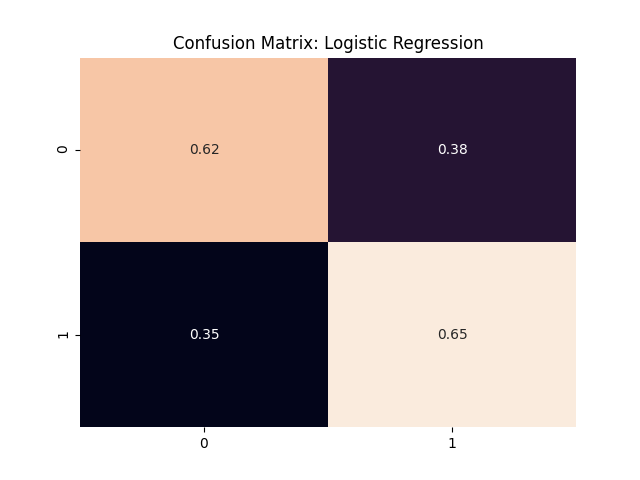

In [27]:
# plot confusion matrix (test)
plt.close()
sn.heatmap(confusion_matrix(y_true_lr, y_pred_lr, labels=[0, 1], normalize='true'), annot=True, cbar=False)
plt.title('Confusion Matrix: Logistic Regression')
#plt.savefig('cmat_lr.png', dpi=200)
plt.show()

%matplot plt

## Random Forest

Note: due to time constraint with each aws session, we chose smaller grids for hyperparameter tuning. With more resources (and time), this could certainly be scaled up to execute a more intensive grid search.

In [28]:
# setup grid search for parameters
rf_params = ParamGridBuilder() \
          .addGrid(rf.numTrees, [int(x) for x in np.linspace(start=5, stop=10, num=2)]) \
          .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start=5, stop=15, num=3)]) \
          .build()

# classification as evaluation
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC') \
               .setLabelCol("cross")

rf_cv = cross_validator(rf_pipeline, rf_params, rf_evaluator)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-28:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [29]:
# run cross validation
rf_cvModel = rf_cv.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-29:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [30]:
rf_cvModel.avgMetrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.6440425120110786, 0.6649085226411394, 0.7398076663704735, 0.6710537137543506, 0.7356724255624028, 0.7615904596989269]

Exception in thread cell_monitor-30:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [31]:
rf_cvModel.getEstimatorParamMaps()[ np.argmax(rf_cvModel.avgMetrics) ]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{Param(parent='RandomForestClassifier_1e1ed3103086', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_1e1ed3103086', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15}

Exception in thread cell_monitor-31:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [32]:
test_rf_predict = rf_cvModel.transform(test)

# collect probability, prediction, and true label to for result analysis (testing data)
y_score_rf = test_rf_predict.select(to_array("probability")[1]).rdd.keys().collect()
y_pred_rf = test_rf_predict.select("prediction").rdd.keys().collect()
y_true_rf = test_rf_predict.select("cross").rdd.keys().collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-32:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [47]:
print("Test AUC: ", rf_evaluator.evaluate(rf_cvModel.transform(test)))
print("Test Accuracy: ", accuracy_score(y_true_rf, y_pred_rf))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-47:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



Test AUC:  0.7648357400316449
Test Accuracy:  0.6903721982534636

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-37:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



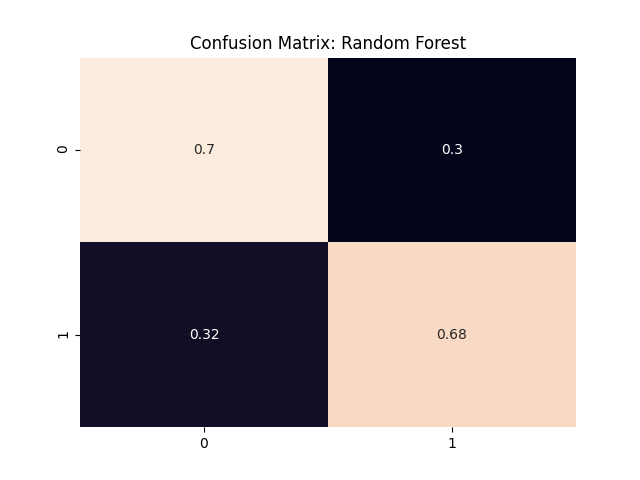

In [37]:
# plot confusion matrix (test)
plt.close()
sn.heatmap(confusion_matrix(y_true_rf, y_pred_rf, labels=[0, 1], normalize='true'), annot=True, cbar=False)
plt.title('Confusion Matrix: Random Forest')
#plt.savefig('cmat_rf.png', dpi=200)
plt.show()

%matplot plt

## Comparison Across Models

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-58:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



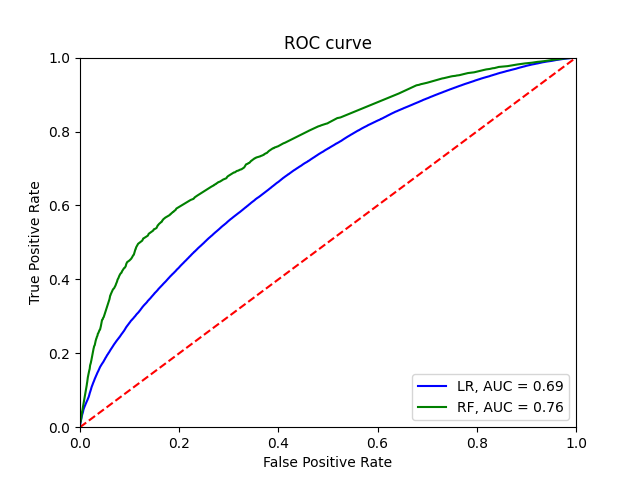

In [58]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_true_lr, y_score_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true_rf, y_score_rf)

plt.close()

plt.title('ROC curve')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'LR, AUC = %0.2f' % lr_evaluator.evaluate(lr_cvModel.transform(test)))
plt.plot(fpr_rf, tpr_rf, 'g', label = 'RF, AUC = %0.2f' % lr_evaluator.evaluate(rf_cvModel.transform(test)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('roc.png', dpi=200)
plt.show()

%matplot plt